In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 

import sklearn
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import tree

import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [2]:
df_master = pd.read_csv("master_12-05.csv", index_col=0)
df_master.describe()


,FIPS,year,CDC Week,Count,Disease_INFLUENZA_A,Disease_INFLUENZA_B,Disease_INFLUENZA_UNSPECIFIED,flu,fluSymptoms,fever,cough,soreThroat,Target,VaxRate,PRCP,SNOW,TAVG,TMAX,TMIN,SNOWDepth
count,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,18592.000000,18592.000000,18592.000000,18592.000000,18592.000000,19956.000000,9540.000000,18462.000000,15685.000000,18187.000000,18192.000000,18188.000000,15062.000000
mean,36063.424900,2014.174402,24.816434,26.010458,20.003088,5.811604,0.195767,0.026605,0.020833,0.287768,0.256351,0.260344,26.124424,0.555987,0.131613,0.486394,38.083467,46.986435,29.187038,2.208371
std,35.586314,2.992755,18.086529,88.217416,68.727437,29.215823,1.604029,0.090495,0.079796,0.149518,0.178057,0.168710,88.469715,0.089235,0.136317,1.070909,13.208433,14.038245,12.852083,4.444374
min,36001.000000,2009.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.337000,0.000000,0.000000,-5.785714,6.375000,-23.142857,0.000000
25%,36033.000000,2012.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.002475,0.001258,0.204321,0.139920,0.140832,0.000000,0.520000,0.035714,0.000000,28.500000,36.142857,20.714286,0.000000
50%,36065.000000,2014.000000,17.000000,2.000000,1.000000,0.000000,0.000000,0.005558,0.002965,0.271068,0.221400,0.247043,2.000000,0.591000,0.098571,0.000000,37.928571,46.285714,29.500000,0.000000
75%,36095.000000,2017.000000,44.000000,14.000000,10.000000,2.000000,0.000000,0.013376,0.008617,0.355073,0.332691,0.364779,15.000000,0.620000,0.185536,0.500000,48.428571,58.142857,38.428571,2.333333
max,36123.000000,2019.000000,53.000000,2401.000000,1213.000000,1166.000000,92.000000,1.000000,0.915000,1.244567,1.245430,1.016013,2401.000000,0.721000,2.820000,15.000000,70.750000,86.000000,67.000000,38.285714


Features to consider

In [3]:
#List of all the features to consider including target variable
columns = ['year','CDC Week','Week Ending Date','PRCP','TAVG','Target','Count', 'SNOWDepth', 'UnempRate','GDP', 'Population','VaxRate', 'flu', 'fluSymptoms','fever','cough', 'soreThroat']
features_withTarget = ['year','CDC Week','PRCP','TAVG', 'SNOWDepth','Count', 'UnempRate','GDP', 'Population','VaxRate', 'Target', 'flu', 'fluSymptoms','fever','cough', 'soreThroat']
target_variable = 'Target'
features = features_withTarget.copy()
features.remove(target_variable)
print("columns = ", columns)
print("features = ",features )
print("target_variable = ",target_variable )
df_master_modified = df_master[columns]


for column in df_master_modified.columns:
  if column != 'Week Ending Date':
    df_master_modified[column] = pd.to_numeric(df_master_modified[column],errors='coerce')
print("Shape of dataframe = ", df_master_modified.shape)


columns =  ['year', 'CDC Week', 'Week Ending Date', 'PRCP', 'TAVG', 'Target', 'Count', 'SNOWDepth', 'UnempRate', 'GDP', 'Population', 'VaxRate', 'flu', 'fluSymptoms', 'fever', 'cough', 'soreThroat']
features =  ['year', 'CDC Week', 'PRCP', 'TAVG', 'SNOWDepth', 'Count', 'UnempRate', 'GDP', 'Population', 'VaxRate', 'flu', 'fluSymptoms', 'fever', 'cough', 'soreThroat']
target_variable =  Target
Shape of dataframe =  (20080, 17)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Handling missing data

In [4]:
def missing_data_handle(dataframe, method = "drop"):
  if method == "drop":
    dataframe_updated = dataframe.dropna()
    #dataframe_updated = dataframe_updated.drop(columns = ['Week Ending Date'])
    return dataframe_updated
  elif method == "avg_over_month":
    #print("nans before averaging over month = ", dataframe.isna().sum())
    dataframe['Date'] = pd.to_datetime(dataframe['Week Ending Date'])
    dataframe_updated = dataframe.fillna(dataframe.groupby(dataframe.Date.dt.month).transform('mean'))
    #print("nans after averaging over month = ", dataframe.isna().sum())
    #print(dataframe.head())
    dataframe_updated = dataframe_updated.drop(columns = ["Date"])
    return dataframe_updated
  else:
    print("Invalid method")
    return dataframe

df_master_modified = missing_data_handle(dataframe = df_master_modified, method = "avg_over_month")
df_master_modified.shape

columns_to_remove = ['Week Ending Date']
df_master_modified = df_master_modified.drop(columns = columns_to_remove)
#df_master_modified['Count'] = pd.to_numeric(df_master_modified['Count'],errors='coerce')

'''print(df_master_modified.shape)

for column in df_master_modified.columns:
   df_master_modified[column] = pd.to_numeric(df_master_modified[column],errors='coerce')
  
df_master_modified = df_master_modified.dropna()'''
print(df_master_modified.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(20080, 16)


Preprocessing

In [0]:
#columns to remove
#columns_to_remove = ['Week Ending Date']
#df_master_modified = df_master_modified.drop(columns = columns_to_remove)

#Divide into features and dependent variable 
X = df_master_modified[features]
y = df_master_modified[target_variable]

#Divide into Training set and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0, shuffle = False)

#Scaling
mm_scaler = sklearn.preprocessing.MinMaxScaler()
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

Linear Regression model

In [6]:
def pred_model_regr(X_train, y_train, X_test, y_test ):
  model_regr = linear_model.LinearRegression()
  model_regr.fit(X_train, y_train)
  y_pred_regression = model_regr.predict(X_test)
  Test_r2_score_regression = metrics.r2_score(y_test, y_pred_regression)
  print("R2 Score for Regression on testing data = {}" .format(Test_r2_score_regression * 100))

  y_train_pred_regression = model_regr.predict(X_train)
  Train_r2_score_regression = metrics.r2_score(y_train, y_train_pred_regression)
  print("R2 Score for Regression on training data = {}" .format(Train_r2_score_regression * 100))

  return model_regr, Test_r2_score_regression, Train_r2_score_regression

model_regr, regr_test_score, regr_train_score = pred_model_regr(X_train_scaled, y_train, X_test_scaled, y_test )

R2 Score for Regression on testing data = 70.97165150809633
R2 Score for Regression on training data = 69.20866812455351


Stochastic Gradient Descent

In [7]:
def pred_model_sgd(X_train, y_train, X_test, y_test):
  model_sgd = linear_model.SGDRegressor()
  model_sgd.fit(X_train, y_train)
  y_train_pred_sgd = model_sgd.predict(X_test)
  Test_r2_score_sgd = metrics.r2_score(y_test, y_train_pred_sgd)
  print("R2 Score for Stochastic Gradient Descent on testing data = {}" .format(Test_r2_score_sgd * 100))

  y_train_pred_sgd = model_sgd.predict(X_train)
  Train_r2_score_sgd = metrics.r2_score(y_train, y_train_pred_sgd)
  print("R2 Score for Stochastic Gradient Descent on training data = {}" .format(Train_r2_score_sgd * 100))

  return model_sgd, Test_r2_score_sgd, Train_r2_score_sgd

model_sgd, sgd_test_score, sgd_test_score = pred_model_sgd(X_train_scaled, y_train, X_test_scaled, y_test )

R2 Score for Stochastic Gradient Descent on testing data = 69.8783041246983
R2 Score for Stochastic Gradient Descent on training data = 68.35099554842577


SVM




In [8]:
def pred_model_SVM(X_train, y_train, X_test, y_test):
  model_svm = svm.SVR(max_iter= 100000)
  model_svm.fit(X_train, y_train)
  y_train_pred_svm = model_svm.predict(X_test)
  Test_r2_score_svm = metrics.r2_score(y_test, y_train_pred_svm)
  print("R2 Score for Support Vector Machine on testing data = {}" .format(Test_r2_score_svm * 100))

  y_train_pred_svm = model_svm.predict(X_train)
  Train_r2_score_svm = metrics.r2_score(y_train, y_train_pred_svm)
  print("R2 Score for Support Vector Machine on training data = {}" .format(Train_r2_score_svm * 100))

  return model_svm, Test_r2_score_svm, Train_r2_score_svm

model_svm, svm_test_score, svm_train_score = pred_model_SVM(X_train_scaled, y_train, X_test_scaled, y_test )

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


R2 Score for Support Vector Machine on testing data = 4.279950189189985
R2 Score for Support Vector Machine on training data = 4.2645025244942625


Decision Trees

In [9]:
def pred_model_dt(X_train, y_train, X_test, y_test):
  model_dt = tree.DecisionTreeRegressor()
  model_dt.fit(X_train, y_train)
  y_pred_decisionTree = model_dt.predict(X_test)
  Test_r2_score_decisionTree = metrics.r2_score(y_test, y_pred_decisionTree)
  print("R2 Score for Decision Tree on testing data = {}" .format(Test_r2_score_decisionTree * 100))

  y_train_pred_regression = model_dt.predict(X_train)
  Train_r2_score_decisionTree = metrics.r2_score(y_train, y_train_pred_regression)
  print("R2 Score for Decision Tree on training data = {}" .format(Train_r2_score_decisionTree * 100))

  return model_dt, Test_r2_score_decisionTree, Train_r2_score_decisionTree

model_dt, dt_test_score, dt_train_score = pred_model_dt(X_train_scaled, y_train, X_test_scaled, y_test)

R2 Score for Decision Tree on testing data = 74.39405735079761
R2 Score for Decision Tree on training data = 99.99965240114513


As the R2 score on training data is much better than testing data, we can say that our model suffers from "High Variance"

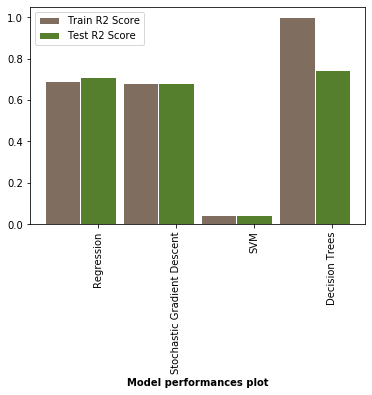

In [10]:
model_scores = {
    "Regression": [regr_test_score, regr_train_score],
    "Stochastic Gradient Descent": [sgd_test_score, sgd_test_score],
    "SVM": [svm_test_score, svm_train_score],
    "Decision Trees": [dt_test_score, dt_train_score]}

barWidth = 0.45

r1 = np.arange(len(model_scores.keys()))
r2 = [x + barWidth for x in r1]

plt.bar(r1, [value[1] for key, value in model_scores.items()], color='#7f6d5f', width=barWidth, edgecolor='white', label='Train R2 Score')
plt.bar(r2, [value[0] for key, value in model_scores.items()], color='#557f2d', width=barWidth, edgecolor='white', label='Test R2 Score')

plt.xlabel('Model performances plot', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(model_scores.keys()))], [key for key, value in model_scores.items()], rotation = 90)
 
plt.legend()
plt.show()

feature_importance =  [0.00362719 0.09513719 0.00565465 0.01431607 0.00922344 0.74388082
 0.00743542 0.01190346 0.02358954 0.01509866 0.00934496 0.01213974
 0.02012626 0.01345555 0.01506706]


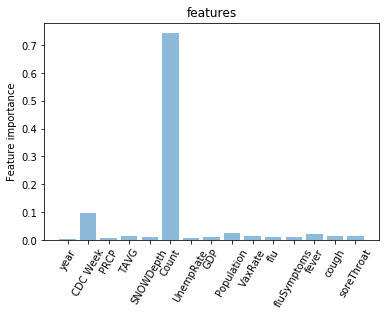

In [11]:
feature_importance = model_dt.feature_importances_
feature_importance_sorted = (np.sort(feature_importance))[::-1]
print("feature_importance = ", feature_importance)

y_pos = np.arange(len(features))
plt.bar(y_pos,feature_importance, align='center', alpha=0.5)
plt.xticks(y_pos, X_train.columns[:len(features)])
plt.ylabel('Feature importance')
plt.title('features')
plt.xticks(rotation=60)

plt.show()

Selecting best min sample leaf values and min sample split values for decision trees

In [12]:
min_samples_split_values = [int(i) for i in np.logspace(1, 12, num=10, base=2)]
min_samples_leaf_values = [int(i) for i in np.logspace(1, 12, num=10, base=2)]

def testTrees(x_train, x_test, y_train, y_test, split, leaf):
    '''
    Build a function that takes in tree hyperparams, data and returns accuracy on test data
    '''
    model = tree.DecisionTreeRegressor(criterion='mse',min_samples_leaf = leaf, min_samples_split = split)
    
    model.fit(x_train,y_train)
    test_p = model.predict(x_test)
    train_p = model.predict(x_train)
    
    test_r2_score = metrics.r2_score(y_test, test_p)
    train_r2_score = metrics.r2_score(y_train, train_p)

    return train_r2_score, test_r2_score
 
res = dict()
train_res = dict()
for s in min_samples_leaf_values:
    res[s] = list()
    train_res[s] = list()

for l in min_samples_leaf_values:
    for s in min_samples_split_values:
        train_r2_score, test_r2_score = testTrees(X_train_scaled, X_test_scaled, y_train, y_test, s, l)
        res[s].append(test_r2_score)
        train_res[s].append(train_r2_score)

#To get the best test score
maximum = max(res, key=res.get)
print("min sample leaf value = {}, sample split value = {} for the best R2 score = {}" .format(s ,res[maximum].index(max(res[maximum])) , max(res[maximum]) * 100))
#To get train value corresponding to best test result
optim_dt_test_score = max(res[maximum])
optim_dt_train_score = train_res[maximum][res[maximum].index(max(res[maximum]))]
print("Train R2 score corresponding to best test result = " ,train_res[maximum][res[maximum].index(max(res[maximum]))] * 100)

min sample leaf value = 4096, sample split value = 2 for the best R2 score = 81.8672161693052
Train R2 score corresponding to best test result =  89.31873044366583


We can see that the train R2 score is still higher than test score. This could be made better using ensember model

Text(0.5, 1.0, 'Holdout Accuracy by Hyperparameters')

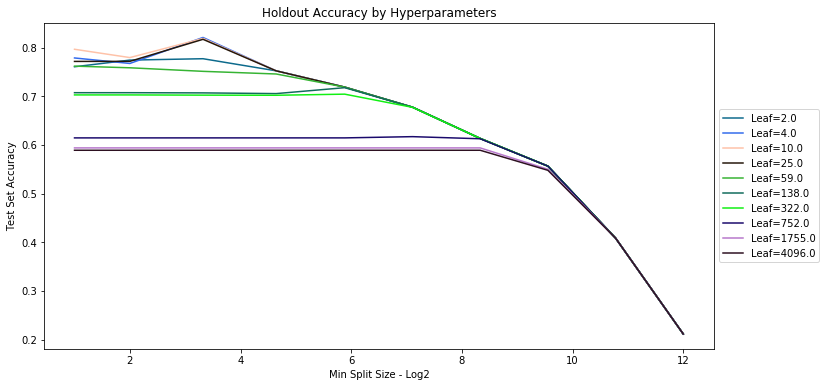

In [13]:
def r():
    return np.random.rand()

fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(111)

for l in min_samples_leaf_values:
    plt.plot(np.log2(min_samples_split_values), res[l], 
             color=(r(),r(),r()), label='Leaf={}'.format(np.floor(l)))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Min Split Size - Log2')
ax.set_ylabel('Test Set Accuracy')
plt.title('Holdout Accuracy by Hyperparameters')

In [14]:
def pred_model_rf(X_train, y_train, X_test, y_test):
  model_rf = ensemble.RandomForestRegressor(n_estimators = 500)
  model_rf.fit(X_train, y_train)
  y_train_pred_randomForest = model_rf.predict(X_test)
  Test_r2_score_randomForest = metrics.r2_score(y_test, y_train_pred_randomForest)
  print("R2 Score for Random Forest on testing data = {}" .format(Test_r2_score_randomForest * 100))

  y_train_pred_randomForest = model_rf.predict(X_train)
  Train_r2_score_randomForest = metrics.r2_score(y_train, y_train_pred_randomForest)
  print("R2 Score for Random Forest on training data = {}" .format(Train_r2_score_randomForest * 100))

  return model_rf, Test_r2_score_randomForest, Train_r2_score_randomForest


model_rf, rf_test_score, rf_train_score = pred_model_rf(X_train_scaled, y_train, X_test_scaled, y_test )

R2 Score for Random Forest on testing data = 88.83998386532657
R2 Score for Random Forest on training data = 98.32548275279646


In [15]:
#Hyperparameter tuning
def pred_model_rf_hp_tuning(X_train, y_train, X_test, y_test):
  best_test_Score = 0
  for estimator in range(100,1100,200):
    model_rf = ensemble.RandomForestRegressor(n_estimators = estimator)
    model_rf.fit(X_train, y_train)
    y_train_pred_randomForest = model_rf.predict(X_test)
    Test_r2_score_randomForest = metrics.r2_score(y_test, y_train_pred_randomForest)
    print("R2 Score for Random Forest on testing data = {} for estimator = {}" .format(Test_r2_score_randomForest * 100, estimator))

    y_train_pred_randomForest = model_rf.predict(X_train)
    Train_r2_score_randomForest = metrics.r2_score(y_train, y_train_pred_randomForest)
    print("R2 Score for Random Forest on training data = {}  for estimator = {}" .format(Train_r2_score_randomForest * 100, estimator))

    if best_test_Score < Test_r2_score_randomForest:
      optimum_estimator = estimator

  return optimum_estimator

optimum_estimator = pred_model_rf_hp_tuning(X_train_scaled, y_train, X_test_scaled, y_test )
print("Optimum Estimator Value= ",optimum_estimator )

R2 Score for Random Forest on testing data = 88.54739765651611 for estimator = 100
R2 Score for Random Forest on training data = 98.18023898875117  for estimator = 100
R2 Score for Random Forest on testing data = 88.89603938664256 for estimator = 300
R2 Score for Random Forest on training data = 98.2998932865046  for estimator = 300
R2 Score for Random Forest on testing data = 88.94566777740651 for estimator = 500
R2 Score for Random Forest on training data = 98.36395981728042  for estimator = 500
R2 Score for Random Forest on testing data = 89.00125667099066 for estimator = 700
R2 Score for Random Forest on training data = 98.32685259643688  for estimator = 700
R2 Score for Random Forest on testing data = 89.07088059268082 for estimator = 900
R2 Score for Random Forest on training data = 98.35970778412714  for estimator = 900
Optimum Estimator Value=  900


K fold Cross Validation

In [16]:
n_splits = 5
tscv = model_selection.TimeSeriesSplit(n_splits=n_splits)
split_number = 0
best_r2_test = 0

r2_score_cv = []
for train_index, test_index in tscv.split(X):
  split_number += 1
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
  y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

  mm_scaler = sklearn.preprocessing.MinMaxScaler()
  X_train_cv_scaled = mm_scaler.fit_transform(X_train_cv)
  X_test_cv_scaled = mm_scaler.transform(X_test_cv)

  model_rf = sklearn.ensemble.RandomForestRegressor(n_estimators = optimum_estimator)
  model_rf.fit(X_train_cv_scaled, y_train_cv)
  y_train_pred_randomForest = model_rf.predict(X_test_cv_scaled)
  Test_r2_score_randomForest = metrics.r2_score(y_test_cv, y_train_pred_randomForest)
  print("R2 Score for Random Forest on testing data = {} for split number = {}" .format(Test_r2_score_randomForest * 100, split_number))

  y_train_pred_randomForest = model_rf.predict(X_train_cv_scaled)
  Train_r2_score_randomForest = metrics.r2_score(y_train_cv, y_train_pred_randomForest)
  print("R2 Score for Random Forest on training data = {} for split number = {}" .format(Train_r2_score_randomForest * 100, split_number))

  r2_score_cv.append(Test_r2_score_randomForest)

  if Test_r2_score_randomForest > best_r2_test:
    best_r2_test = Test_r2_score_randomForest
    best_r2_train = Train_r2_score_randomForest
    best_split_model = copy.deepcopy(model_rf)
    best_split_X_train = X_train_cv.copy()
    best_split_X_test = y_train_cv.copy()

print("R2 Score for the best Random Forest model on testing data = {}" .format(best_r2_test * 100))

R2 Score for Random Forest on testing data = 70.91419960898368 for split number = 1
R2 Score for Random Forest on training data = 96.68106803820558 for split number = 1
R2 Score for Random Forest on testing data = 79.87293608202344 for split number = 2
R2 Score for Random Forest on training data = 97.18374647677719 for split number = 2
R2 Score for Random Forest on testing data = 86.83103752013913 for split number = 3
R2 Score for Random Forest on training data = 98.14401823478163 for split number = 3
R2 Score for Random Forest on testing data = 83.64133966418595 for split number = 4
R2 Score for Random Forest on training data = 98.3578717089333 for split number = 4
R2 Score for Random Forest on testing data = 92.4113990333624 for split number = 5
R2 Score for Random Forest on training data = 98.43601968685101 for split number = 5
R2 Score for the best Random Forest model on testing data = 92.4113990333624


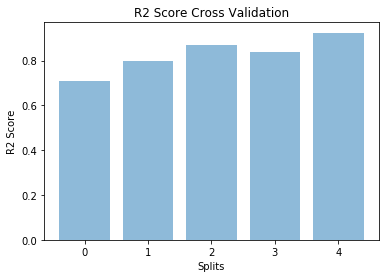

In [17]:
y_pos = np.arange(n_splits)
plt.bar(y_pos,r2_score_cv, align='center', alpha=0.5)
plt.xticks(y_pos,range(n_splits))
plt.ylabel('R2 Score')
plt.xlabel('Splits')
plt.title('R2 Score Cross Validation')

plt.show()

feature_importance =  [0.01267578 0.09169108 0.01116694 0.01943828 0.00620425 0.72839432
 0.0096247  0.00773066 0.02459893 0.02463775 0.00998263 0.01046736
 0.01211101 0.01826547 0.01301083]


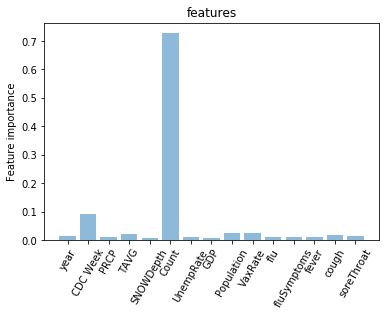

In [18]:
feature_importance = model_rf.feature_importances_
feature_importance_sorted = (np.sort(feature_importance))[::-1]
print("feature_importance = ", feature_importance)

y_pos = np.arange(len(features))
plt.bar(y_pos,feature_importance, align='center', alpha=0.5)
plt.xticks(y_pos, X_train.columns[:len(features)])
plt.ylabel('Feature importance')
plt.title('features')
plt.xticks(rotation=60)

plt.show()

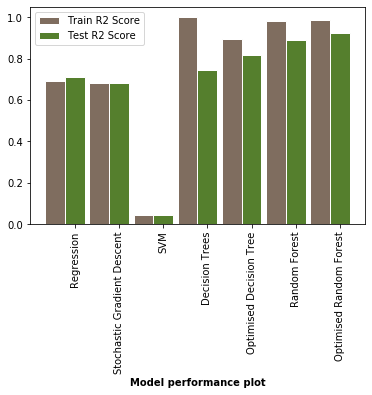

In [19]:
extended_model_scores = {
    "Regression": [regr_test_score, regr_train_score],
    "Stochastic Gradient Descent": [sgd_test_score, sgd_test_score],
    "SVM": [svm_test_score, svm_train_score],
    "Decision Trees": [dt_test_score, dt_train_score], 
    "Optimised Decision Tree": [optim_dt_test_score, optim_dt_train_score],
    "Random Forest": [rf_test_score, rf_train_score],
    "Optimised Random Forest" : [best_r2_test ,best_r2_train]}

barWidth = 0.45

r1 = np.arange(len(extended_model_scores.keys()))
r2 = [x + barWidth for x in r1]

plt.bar(r1, [value[1] for key, value in extended_model_scores.items()], color='#7f6d5f', width=barWidth, edgecolor='white', label='Train R2 Score')
plt.bar(r2, [value[0] for key, value in extended_model_scores.items()], color='#557f2d', width=barWidth, edgecolor='white', label='Test R2 Score')

plt.xlabel('Model performance plot', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(extended_model_scores.keys()))], [key for key, value in extended_model_scores.items()], rotation = 90)
 
plt.legend()
plt.show()